In [2]:
# Import necessary PyTorch libraries
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms


# Additional libraries for visualization and utilities
import matplotlib.pyplot as plt
import numpy as np
from unet_decoder import UNetDecoder

In [3]:
def get_device():
    """Selects the best available device for PyTorch computations.

    Returns:
        torch.device: The selected device.
    """

    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
print(f"using device: {device}")

using device: mps


In [4]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Normalize, ToTensor,Resize

from torch.utils.data import DataLoader, random_split

# Define the transformation with resizing
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the Omniglot dataset
dataset = datasets.Omniglot(root='./data', download=True, transform=transform, background=True)

# Print the total number of images in the dataset
print(f"Total number of images in the dataset: {len(dataset)}")

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Print the number of images in the train and validation sets
print(f"Number of images in the training set: {len(train_dataset)}")
print(f"Number of images in the validation set: {len(val_dataset)}")

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Inspect the contents of the train_loader
train_batches = 0
for batch in train_loader:
    train_batches += 1

print(f"Number of batches in the training loader: {train_batches}")
print(f"Total number of images in the training loader: {train_batches * 128}")

Files already downloaded and verified
Total number of images in the dataset: 19280
Number of images in the training set: 15424
Number of images in the validation set: 3856
Number of batches in the training loader: 121
Total number of images in the training loader: 15488


In [5]:
class ColdDiffusionModel(nn.Module):
    def __init__(self, input_shape, T=1000):
        super(ColdDiffusionModel, self).__init__()
        self.input_shape = input_shape
        self.T = T
        self.decoder = UNetDecoder(n_channels=input_shape[0])

        # Define the noise schedule
        self.alpha = self.create_noise_schedule(T)

    def create_noise_schedule(self, T):
        beta_start = 0.0001
        beta_end = 0.02
        betas = torch.linspace(beta_start, beta_end, T)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        return alphas_cumprod

    def forward(self, x):

        # Calculate the gaussian noise tensor
        batch_size = x.shape[0]
        epsilon = torch.randn(batch_size, 1, 28, 28).to(device)
        
        torch.cuda.empty_cache()

        #sample a timestep t
        t = np.random.randint(0, self.T)
        # Retrieve noise scheduler alpha_T
        alpha_t = self.alpha[t]

        # Calculate square root alphas
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
        
        # Perform the weighted sum
        x_t = sqrt_alpha_t * x + sqrt_one_minus_alpha_t * epsilon

        torch.cuda.empty_cache()

        #Calculate the timestep tensor
        t = torch.tensor([t] * x_t.size(0), dtype=torch.long).to(x_t.device)

        # Perform the reconstruction process using Algorithm 2
        estimated_x = self.decoder(x_t,t)
        torch.cuda.empty_cache()
        return estimated_x

In [6]:
import os

def save_checkpoint(epoch, model, optimizer, filename="checkpoint.pth"):
    """Saves the model and optimizer state at the specified path."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)
    print(f"Checkpoint saved at epoch {epoch} to {filename}")


def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """Loads the model and optimizer state from the specified path."""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from {filename}, resuming training from epoch {epoch}")
        return epoch
    else:
        print(f"No checkpoint found at {filename}, starting from scratch.")
        return -1

In [8]:
import time  # Importing time to log the duration
from tqdm import tqdm


def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient computation during validation
        for data, _ in val_loader:
            data = data.to(device)
            estimated_image = model(data)
            reconstruction_loss = nn.functional.l1_loss(data, estimated_image)
            total_val_loss += reconstruction_loss.item()  # Accumulate the validation loss
    
    avg_val_loss = total_val_loss / len(val_loader)  # Calculate average loss
    return avg_val_loss

def train(model, optimizer, train_loader, device, start_epoch, num_epochs, filename):
    model.train()

    for epoch in range(start_epoch+1, num_epochs):
        epoch_loss = 0.0
        epoch_start_time = time.time()  # Time tracking for the epoch

        print(f"Starting epoch {epoch+1}/{num_epochs}")
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            data = data.to(device)

            # Forward pass
            estimated_image = model(data)
            total_loss = nn.functional.l1_loss(data, estimated_image)

            # Backward pass
            if not torch.isnan(total_loss).any():
                total_loss.backward()
            else:
                print(f"Warning: NaN detected in total_loss at batch {batch_idx+1}, skipping backward pass.")

            optimizer.step()  # Only step the optimizer every `accumulation_steps`
            optimizer.zero_grad()  # Reset gradients only after accumulation

            # Safe-guarding against NaN for epoch_loss
            if not torch.isnan(total_loss).any():
                epoch_loss += total_loss.item()
            else:
                print(f"NaN detected, not adding to epoch_loss at batch {batch_idx+1}")

        # Save the model checkpoint
        save_checkpoint(epoch, model, optimizer, filename)
        
        # Average loss after training for an epoch
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {time.time() - epoch_start_time:.2f} seconds, Avg Loss: {avg_loss}")

        # Validation phase
        avg_val_loss = validate(model, val_loader, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] validation completed, Avg Validation Loss: {avg_val_loss}")

    return model


In [107]:
# Define the input shape
input_shape = (1, 28, 28)

# Create an instance of Gaussian Diffusion model
model = ColdDiffusionModel(input_shape).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# Define the number of epochs and loss weights
num_epochs = 400

# Filename
filename = "omniglot_cold_l1.pth"

# Load the model training checkpoint
start_epoch = load_checkpoint(model, optimizer, filename)
    
print(f"The training ended in epoch number: {start_epoch}")

# Train the model
trained_model = train(model, optimizer, train_loader, device, start_epoch, num_epochs, filename)

Checkpoint loaded from omniglot_cold_l1.pth, resuming training from epoch 349
The training ended in epoch number: 349
Starting epoch 351/400


Checkpoint saved at epoch 350 to omniglot_cold_l1.pth
Epoch [351/400] completed in 22.36 seconds, Avg Loss: 0.1432987860719527
Epoch [351/400] validation completed, Avg Validation Loss: 0.22421935681373842
Starting epoch 352/400


Checkpoint saved at epoch 351 to omniglot_cold_l1.pth
Epoch [352/400] completed in 21.87 seconds, Avg Loss: 0.16114567466511215
Epoch [352/400] validation completed, Avg Validation Loss: 0.15520435331329221
Starting epoch 353/400


Checkpoint saved at epoch 352 to omniglot_cold_l1.pth
Epoch [353/400] completed in 21.88 seconds, Avg Loss: 0.15709366729436827
Epoch [353/400] validation completed, Avg Validation Loss: 0.15453696683529886
Starting epoch 354/400


Checkpoint saved at epoch 353 to omniglot_cold_l1.pth
Epoch [354/400] completed in 21.86 seconds, Avg Loss: 0.15650337663563815
Epoch [354/400] validation completed, Avg Validation Loss: 0.15612703465646313
Starting epoch 355/400


Checkpoint saved at epoch 354 to omniglot_cold_l1.pth
Epoch [355/400] completed in 21.89 seconds, Avg Loss: 0.139152250321936
Epoch [355/400] validation completed, Avg Validation Loss: 0.13020788553741672
Starting epoch 356/400


Checkpoint saved at epoch 355 to omniglot_cold_l1.pth
Epoch [356/400] completed in 21.88 seconds, Avg Loss: 0.12574164760260542
Epoch [356/400] validation completed, Avg Validation Loss: 0.11286567355836591
Starting epoch 357/400


Checkpoint saved at epoch 356 to omniglot_cold_l1.pth
Epoch [357/400] completed in 21.88 seconds, Avg Loss: 0.11819093391176097
Epoch [357/400] validation completed, Avg Validation Loss: 0.12901165264268075
Starting epoch 358/400


Checkpoint saved at epoch 357 to omniglot_cold_l1.pth
Epoch [358/400] completed in 21.87 seconds, Avg Loss: 0.119816860599705
Epoch [358/400] validation completed, Avg Validation Loss: 0.11593013046489607
Starting epoch 359/400


Checkpoint saved at epoch 358 to omniglot_cold_l1.pth
Epoch [359/400] completed in 21.87 seconds, Avg Loss: 0.11185345835675878
Epoch [359/400] validation completed, Avg Validation Loss: 0.09848685190081596
Starting epoch 360/400


Checkpoint saved at epoch 359 to omniglot_cold_l1.pth
Epoch [360/400] completed in 21.88 seconds, Avg Loss: 0.10684676873997963
Epoch [360/400] validation completed, Avg Validation Loss: 0.11148199955782583
Starting epoch 361/400


Checkpoint saved at epoch 360 to omniglot_cold_l1.pth
Epoch [361/400] completed in 21.86 seconds, Avg Loss: 0.10861665388369117
Epoch [361/400] validation completed, Avg Validation Loss: 0.1145406057757716
Starting epoch 362/400


Checkpoint saved at epoch 361 to omniglot_cold_l1.pth
Epoch [362/400] completed in 21.97 seconds, Avg Loss: 0.11184911606910307
Epoch [362/400] validation completed, Avg Validation Loss: 0.11255805212403497
Starting epoch 363/400


Checkpoint saved at epoch 362 to omniglot_cold_l1.pth
Epoch [363/400] completed in 21.88 seconds, Avg Loss: 0.10547761671429823
Epoch [363/400] validation completed, Avg Validation Loss: 0.10852048945643249
Starting epoch 364/400


Checkpoint saved at epoch 363 to omniglot_cold_l1.pth
Epoch [364/400] completed in 21.91 seconds, Avg Loss: 0.11621320259195468
Epoch [364/400] validation completed, Avg Validation Loss: 0.1165538264979278
Starting epoch 365/400


Checkpoint saved at epoch 364 to omniglot_cold_l1.pth
Epoch [365/400] completed in 21.93 seconds, Avg Loss: 0.10531999514830753
Epoch [365/400] validation completed, Avg Validation Loss: 0.10625969200965858
Starting epoch 366/400


Checkpoint saved at epoch 365 to omniglot_cold_l1.pth
Epoch [366/400] completed in 21.92 seconds, Avg Loss: 0.10809050862915999
Epoch [366/400] validation completed, Avg Validation Loss: 0.10687094878765845
Starting epoch 367/400


Checkpoint saved at epoch 366 to omniglot_cold_l1.pth
Epoch [367/400] completed in 21.93 seconds, Avg Loss: 0.11365287442314477
Epoch [367/400] validation completed, Avg Validation Loss: 0.10308198041973575
Starting epoch 368/400


Checkpoint saved at epoch 367 to omniglot_cold_l1.pth
Epoch [368/400] completed in 21.93 seconds, Avg Loss: 0.1028818119517412
Epoch [368/400] validation completed, Avg Validation Loss: 0.1254186276346445
Starting epoch 369/400


Checkpoint saved at epoch 368 to omniglot_cold_l1.pth
Epoch [369/400] completed in 21.86 seconds, Avg Loss: 0.11658262890140134
Epoch [369/400] validation completed, Avg Validation Loss: 0.1226054314644106
Starting epoch 370/400


Checkpoint saved at epoch 369 to omniglot_cold_l1.pth
Epoch [370/400] completed in 21.86 seconds, Avg Loss: 0.11082208730003312
Epoch [370/400] validation completed, Avg Validation Loss: 0.12277338323333571
Starting epoch 371/400


Checkpoint saved at epoch 370 to omniglot_cold_l1.pth
Epoch [371/400] completed in 21.87 seconds, Avg Loss: 0.11128600587498796
Epoch [371/400] validation completed, Avg Validation Loss: 0.1140361160280243
Starting epoch 372/400


Checkpoint saved at epoch 371 to omniglot_cold_l1.pth
Epoch [372/400] completed in 21.88 seconds, Avg Loss: 0.10957963994804247
Epoch [372/400] validation completed, Avg Validation Loss: 0.12430307398279829
Starting epoch 373/400


Checkpoint saved at epoch 372 to omniglot_cold_l1.pth
Epoch [373/400] completed in 21.91 seconds, Avg Loss: 0.10990597752561747
Epoch [373/400] validation completed, Avg Validation Loss: 0.11710561787889849
Starting epoch 374/400


Checkpoint saved at epoch 373 to omniglot_cold_l1.pth
Epoch [374/400] completed in 21.92 seconds, Avg Loss: 0.11615108982621392
Epoch [374/400] validation completed, Avg Validation Loss: 0.10170621953664287
Starting epoch 375/400


Checkpoint saved at epoch 374 to omniglot_cold_l1.pth
Epoch [375/400] completed in 21.86 seconds, Avg Loss: 0.11499916911433058
Epoch [375/400] validation completed, Avg Validation Loss: 0.10586058889185229
Starting epoch 376/400


Checkpoint saved at epoch 375 to omniglot_cold_l1.pth
Epoch [376/400] completed in 21.86 seconds, Avg Loss: 0.11103439721286543
Epoch [376/400] validation completed, Avg Validation Loss: 0.11442971887487557
Starting epoch 377/400


Checkpoint saved at epoch 376 to omniglot_cold_l1.pth
Epoch [377/400] completed in 21.87 seconds, Avg Loss: 0.10924289054583666
Epoch [377/400] validation completed, Avg Validation Loss: 0.13036108476620528
Starting epoch 378/400


Checkpoint saved at epoch 377 to omniglot_cold_l1.pth
Epoch [378/400] completed in 21.86 seconds, Avg Loss: 0.11241534201443688
Epoch [378/400] validation completed, Avg Validation Loss: 0.09252465059680323
Starting epoch 379/400


Checkpoint saved at epoch 378 to omniglot_cold_l1.pth
Epoch [379/400] completed in 21.91 seconds, Avg Loss: 0.12456109845810685
Epoch [379/400] validation completed, Avg Validation Loss: 0.11510841139862614
Starting epoch 380/400


Checkpoint saved at epoch 379 to omniglot_cold_l1.pth
Epoch [380/400] completed in 22.02 seconds, Avg Loss: 0.11817422168221602
Epoch [380/400] validation completed, Avg Validation Loss: 0.111095538422946
Starting epoch 381/400


Checkpoint saved at epoch 380 to omniglot_cold_l1.pth
Epoch [381/400] completed in 21.89 seconds, Avg Loss: 0.1132141814744177
Epoch [381/400] validation completed, Avg Validation Loss: 0.12931204190657986
Starting epoch 382/400


Checkpoint saved at epoch 381 to omniglot_cold_l1.pth
Epoch [382/400] completed in 21.86 seconds, Avg Loss: 0.10763463770493495
Epoch [382/400] validation completed, Avg Validation Loss: 0.10550043116053266
Starting epoch 383/400


Checkpoint saved at epoch 382 to omniglot_cold_l1.pth
Epoch [383/400] completed in 21.86 seconds, Avg Loss: 0.1128562852078356
Epoch [383/400] validation completed, Avg Validation Loss: 0.11232095037496859
Starting epoch 384/400


Checkpoint saved at epoch 383 to omniglot_cold_l1.pth
Epoch [384/400] completed in 21.87 seconds, Avg Loss: 0.10436420990077179
Epoch [384/400] validation completed, Avg Validation Loss: 0.10574644107011057
Starting epoch 385/400


Checkpoint saved at epoch 384 to omniglot_cold_l1.pth
Epoch [385/400] completed in 21.86 seconds, Avg Loss: 0.1089433512981396
Epoch [385/400] validation completed, Avg Validation Loss: 0.13101451777883114
Starting epoch 386/400


Checkpoint saved at epoch 385 to omniglot_cold_l1.pth
Epoch [386/400] completed in 21.88 seconds, Avg Loss: 0.11625551987316243
Epoch [386/400] validation completed, Avg Validation Loss: 0.11202364559135129
Starting epoch 387/400


Checkpoint saved at epoch 386 to omniglot_cold_l1.pth
Epoch [387/400] completed in 21.86 seconds, Avg Loss: 0.11514976121146571
Epoch [387/400] validation completed, Avg Validation Loss: 0.11125018468667422
Starting epoch 388/400


Checkpoint saved at epoch 387 to omniglot_cold_l1.pth
Epoch [388/400] completed in 21.86 seconds, Avg Loss: 0.10482515203035321
Epoch [388/400] validation completed, Avg Validation Loss: 0.10358376819039544
Starting epoch 389/400


Checkpoint saved at epoch 388 to omniglot_cold_l1.pth
Epoch [389/400] completed in 21.87 seconds, Avg Loss: 0.10748073952041629
Epoch [389/400] validation completed, Avg Validation Loss: 0.11319195223791946
Starting epoch 390/400


Checkpoint saved at epoch 389 to omniglot_cold_l1.pth
Epoch [390/400] completed in 21.94 seconds, Avg Loss: 0.10504461704822611
Epoch [390/400] validation completed, Avg Validation Loss: 0.11046427305066778
Starting epoch 391/400


Checkpoint saved at epoch 390 to omniglot_cold_l1.pth
Epoch [391/400] completed in 21.88 seconds, Avg Loss: 0.1025228488743921
Epoch [391/400] validation completed, Avg Validation Loss: 0.12663737113677687
Starting epoch 392/400


Checkpoint saved at epoch 391 to omniglot_cold_l1.pth
Epoch [392/400] completed in 21.89 seconds, Avg Loss: 0.11262460162262779
Epoch [392/400] validation completed, Avg Validation Loss: 0.1210618871414373
Starting epoch 393/400


Checkpoint saved at epoch 392 to omniglot_cold_l1.pth
Epoch [393/400] completed in 21.89 seconds, Avg Loss: 0.11078284459173186
Epoch [393/400] validation completed, Avg Validation Loss: 0.10644528011400853
Starting epoch 394/400


Checkpoint saved at epoch 393 to omniglot_cold_l1.pth
Epoch [394/400] completed in 21.96 seconds, Avg Loss: 0.11207169599153778
Epoch [394/400] validation completed, Avg Validation Loss: 0.11421519827337996
Starting epoch 395/400


Checkpoint saved at epoch 394 to omniglot_cold_l1.pth
Epoch [395/400] completed in 21.83 seconds, Avg Loss: 0.11018124408250259
Epoch [395/400] validation completed, Avg Validation Loss: 0.10721709413994704
Starting epoch 396/400


Checkpoint saved at epoch 395 to omniglot_cold_l1.pth
Epoch [396/400] completed in 21.83 seconds, Avg Loss: 0.11297915158562424
Epoch [396/400] validation completed, Avg Validation Loss: 0.11247785581696418
Starting epoch 397/400


Checkpoint saved at epoch 396 to omniglot_cold_l1.pth
Epoch [397/400] completed in 21.83 seconds, Avg Loss: 0.1119765490601378
Epoch [397/400] validation completed, Avg Validation Loss: 0.11463961272590584
Starting epoch 398/400


Checkpoint saved at epoch 397 to omniglot_cold_l1.pth
Epoch [398/400] completed in 21.81 seconds, Avg Loss: 0.10698972957993834
Epoch [398/400] validation completed, Avg Validation Loss: 0.11533298052006191
Starting epoch 399/400


Checkpoint saved at epoch 398 to omniglot_cold_l1.pth
Epoch [399/400] completed in 21.82 seconds, Avg Loss: 0.1118768803806098
Epoch [399/400] validation completed, Avg Validation Loss: 0.09897586907590589
Starting epoch 400/400


Checkpoint saved at epoch 399 to omniglot_cold_l1.pth
Epoch [400/400] completed in 21.82 seconds, Avg Loss: 0.11489953047572828
Epoch [400/400] validation completed, Avg Validation Loss: 0.12032358117041088


In [108]:
# Define the input shape
input_shape = (1, 28, 28)

# Example usage
model = ColdDiffusionModel(input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

start_epoch = load_checkpoint(model, optimizer, filename)
print(f"The training ended in epoch number: {start_epoch}")

Checkpoint loaded from omniglot_cold_l1.pth, resuming training from epoch 399
The training ended in epoch number: 399


## Sampling according to Algorithm 1

In [109]:
import torch
import torch.nn.functional as F

# Define the necessary parameters and variables
T = 1000
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1 - beta
alpha = torch.cumprod(alpha, dim=0)

model.eval()

sampled_data = {}
batch_size = 128


with torch.no_grad():
    for batch_idx in range(32):
        x = torch.randn(batch_size, 1, 28, 28).to(device)
        for s in range(T-1, 0, -1):
            t = torch.tensor([s] * x.size(0), dtype=torch.long).to(device)
            x_hat = model.decoder(x, t)
            z_hat = (1.0/torch.sqrt(1-alpha[s]))* (x - torch.sqrt(alpha[s]) * x_hat) 
            x = torch.sqrt(alpha[s-1]) * x_hat + torch.sqrt(1-alpha[s-1]) * z_hat
            
        # Reverse normalization
        x = x * 0.3081 + 0.1307
        x = (x.clamp(0, 1) * 255).type(torch.uint8)
            
        # Store the sampled images
        for i in range(x.size(0)):
            sampled_data[batch_idx * batch_size + i] = {
                'sampled': x[i].cpu()
            }
        break

In [110]:

# Save the dictionary to a .pt file
torch.save(sampled_data, 'omniglot_cold_alg1.pt')

print("Sampled data saved to 'omniglot_cold_alg1.pt'")


Sampled data saved to 'omniglot_cold_alg1.pt'


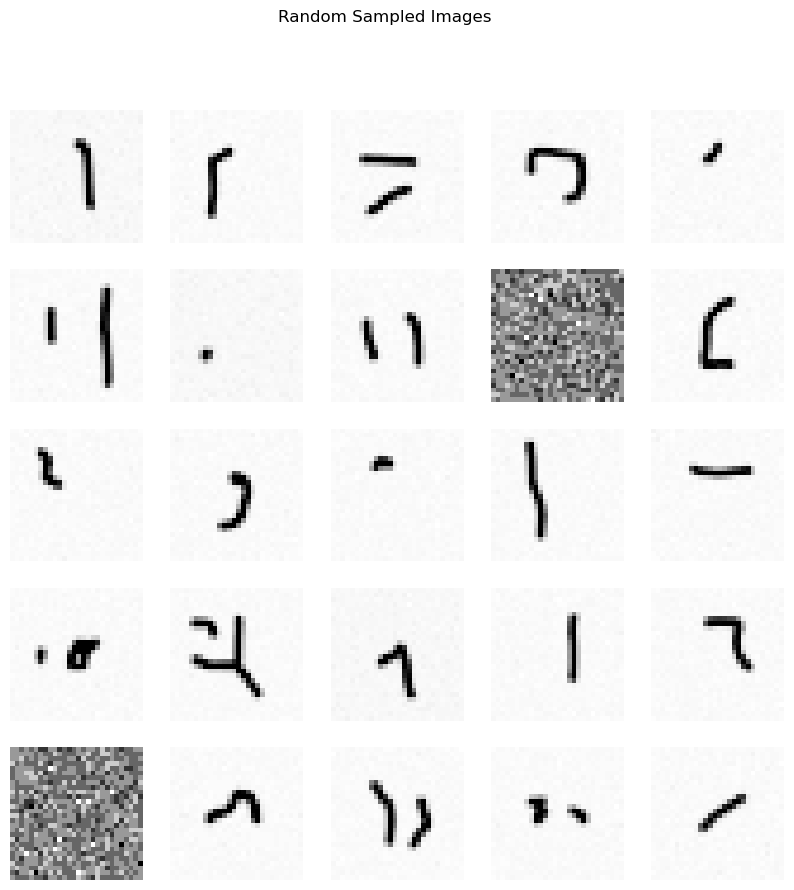

In [121]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the saved data
sampled_data = torch.load('omniglot_cold_alg1.pt')

# Number of images to display in the grid
num_images = 25

# Get random indices
random_indices = np.random.choice(len(sampled_data), num_images, replace=False)

# Initialize the plot
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Loop through the images and plot them
for i, ax in enumerate(axes.flat):
    sampled_image = sampled_data[random_indices[i]]['sampled']
    sampled_image = sampled_image.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(sampled_image, cmap='gray')
    ax.axis('off')

plt.suptitle("Random Sampled Images")
plt.show()

In [112]:
print(len(sampled_data))

128


## Sampling according to Algorithm 2

In [113]:
import torch
import torch.nn.functional as F

# Define the necessary parameters and variables
T = 1000
beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1 - beta
alpha = torch.cumprod(alpha, dim=0)

model.eval()

sampled_data = {}
batch_size = 128


with torch.no_grad():
    for batch_idx in range(32):
        x = torch.randn(batch_size, 1, 28, 28).to(device)
        for s in range(T-1, 0, -1):
            t = torch.tensor([s] * x.size(0), dtype=torch.long).to(device)
            x_hat = model.decoder(x, t)
            z_hat = (1.0/torch.sqrt(1-alpha[s]))* (x - torch.sqrt(alpha[s]) * x_hat)
            D_s_minus_one = torch.sqrt(alpha[s-1]) * x_hat + torch.sqrt(1-alpha[s-1]) * z_hat
            D_s = torch.sqrt(alpha[s]) * x_hat + torch.sqrt(1-alpha[s]) * z_hat
            x = x - D_s + D_s_minus_one
            
        # Reverse normalization
        x = x * 0.3081 + 0.1307
        x = (x.clamp(0, 1) * 255).type(torch.uint8)
            
        # Store the sampled images
        for i in range(x.size(0)):
            sampled_data[batch_idx * batch_size + i] = {
                'sampled': x[i].cpu()
            }
        break

In [114]:

# Save the dictionary to a .pt file
torch.save(sampled_data, 'omniglot_cold_alg2.pt')

print("Sampled data saved to 'omniglot_cold_alg2.pt'")

Sampled data saved to 'omniglot_cold_alg2.pt'


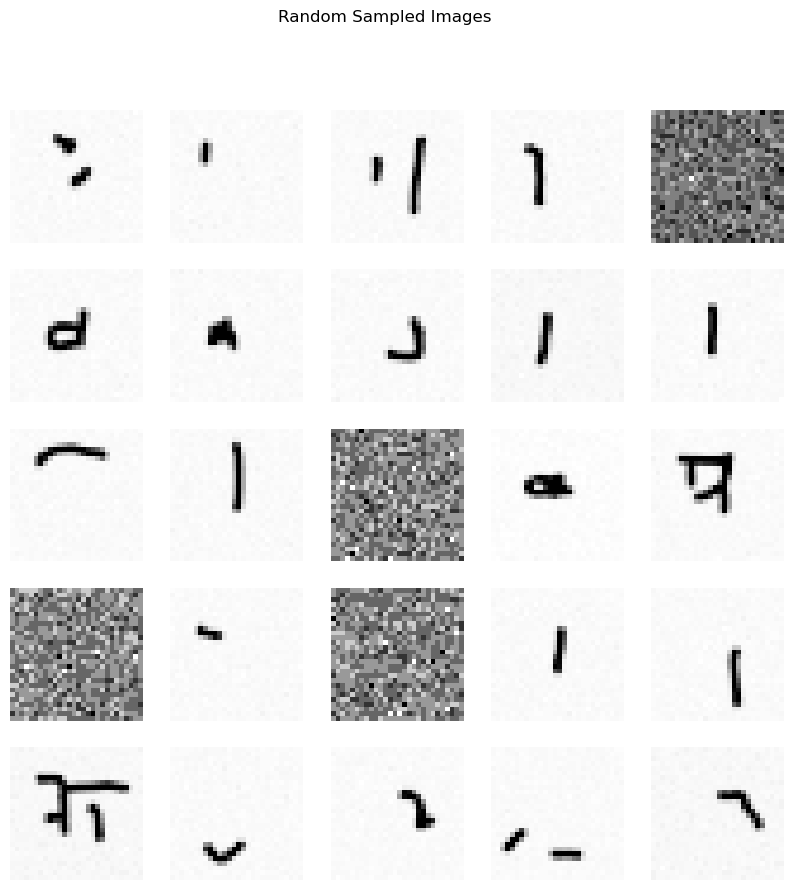

In [119]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the saved data
sampled_data = torch.load('omniglot_cold_alg2.pt')

# Number of images to display in the grid
num_images = 25

# Get random indices
random_indices = np.random.choice(len(sampled_data), num_images, replace=False)

# Initialize the plot
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Loop through the images and plot them
for i, ax in enumerate(axes.flat):
    sampled_image = sampled_data[random_indices[i]]['sampled']
    sampled_image = sampled_image.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(sampled_image, cmap='gray')
    ax.axis('off')

plt.suptitle("Random Sampled Images")
plt.show()